After we have run [income_gdp_pop_sc_dynamics_employment_correlation_matrices](https://www.dropbox.com/s/1s0zkqpf6pdhe93/income_gdp_pop_sc_dynamics_employment_correlation_matrices.ipynb?dl=0), we know a few things about collinearities and correlations of the features with the target variables.  We are going to follow the PCA->RFR route to identify where we can have good predictive models.  RFR will not tell us how these variable are correlated, but for that, we will use more sophisticated modeling techniques.

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import seaborn as sns

%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

%run ./mobilityMLhelpers.ipynb
mlHelpers = mobilityMLhelpers()


gdpFile = helpers.mFiles["gdp"]
piFile = helpers.mFiles["pi"]
hhiFile = helpers.mFiles["hhi"]
populationFile = helpers.mFiles["pop"]
suicideFile = helpers.mFiles["sc"]
employFile = helpers.mFiles["emp"]

In [96]:
compiledFile = MYDIR + "hhi_gdp_pop_sc_emp_yr__preparing_for_modeling.csv"
rawData = pd.read_csv(compiledFile)
myData = rawData.loc[rawData["year"] >= 2010.0]
myData.head()

,county_state,year,BIRTHS,CENSUSPOP,DEATHS,DOMESTICMIG,EMPLOYED,ESTIMATESBASE,GDP,GDP_LOG,...,RNATURALINC,RNETMIG,SCDEATHS,SCRATE,SC_R_DEATH,UNEMPLOYED,UNEMPLOYMENT_RATE_PCT,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars
10,"Abbeville, South Carolina",2010.0,65.0,25417.0,90.0,-67.0,9439.0,25416.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1486.0,13.6,41816.0,1.261684,33143.0
11,"Abbeville, South Carolina",2011.0,229.0,NaN,290.0,-192.0,9437.0,NaN,NaN,NaN,...,-2.420203,-7.379635,NaN,NaN,NaN,1343.0,12.5,43780.0,1.262763,34670.0
12,"Abbeville, South Carolina",2012.0,280.0,NaN,252.0,-106.0,9549.0,NaN,NaN,NaN,...,1.117764,-3.512974,NaN,NaN,NaN,1135.0,10.6,44676.0,1.274018,35067.0
13,"Abbeville, South Carolina",2013.0,273.0,NaN,278.0,-113.0,9540.0,NaN,NaN,NaN,...,-0.200329,-4.527425,NaN,NaN,NaN,1003.0,9.5,45632.0,1.269424,35947.0
14,"Abbeville, South Carolina",2014.0,242.0,NaN,261.0,-76.0,9756.0,NaN,NaN,NaN,...,-0.764680,-3.300197,NaN,NaN,NaN,817.0,7.7,45773.0,1.292694,35409.0


We shall first apply the process to NETMIG as the dependent variable

In [97]:
myPCAdata = myData[[cc for cc in myData.columns if cc != "DOMESTICMIG" and cc != "INTERNATIONALMIG"]].copy()
myPCAdata.drop("county_state", 1, inplace=True)
myPCAdata.drop("CENSUSPOP", 1, inplace=True)
myPCAdata.drop("ESTIMATESBASE", 1, inplace=True)
myPCAdata.interpolate(inplace=True)
myPCAdata.fillna(method="ffill")
myPCAdata.head()

,year,BIRTHS,DEATHS,EMPLOYED,GDP,GDP_LOG,LABOR_FORCE,NATURALINC,NETMIG,NPOPCHG_,...,RNATURALINC,RNETMIG,SCDEATHS,SCRATE,SC_R_DEATH,UNEMPLOYED,UNEMPLOYMENT_RATE_PCT,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars
10,2010.0,65.0,90.0,9439.0,NaN,NaN,10925.0,-25.0,-65.0,-88.0,...,NaN,NaN,NaN,NaN,NaN,1486.0,13.6,41816.0,1.261684,33143.0
11,2011.0,229.0,290.0,9437.0,NaN,NaN,10780.0,-61.0,-186.0,-247.0,...,-2.420203,-7.379635,NaN,NaN,NaN,1343.0,12.5,43780.0,1.262763,34670.0
12,2012.0,280.0,252.0,9549.0,NaN,NaN,10684.0,28.0,-88.0,-62.0,...,1.117764,-3.512974,NaN,NaN,NaN,1135.0,10.6,44676.0,1.274018,35067.0
13,2013.0,273.0,278.0,9540.0,NaN,NaN,10543.0,-5.0,-113.0,-120.0,...,-0.200329,-4.527425,NaN,NaN,NaN,1003.0,9.5,45632.0,1.269424,35947.0
14,2014.0,242.0,261.0,9756.0,NaN,NaN,10573.0,-19.0,-82.0,-104.0,...,-0.764680,-3.300197,NaN,NaN,NaN,817.0,7.7,45773.0,1.292694,35409.0


In [98]:
myPCAdata.dropna(inplace=True)

Before applying PCA, we should center and scale the data, but first split into the training and testing data sets.  The runPCA(...) method in mobilityMLhelpers takes care of that

------------PCA Explained Variance------------
[9.24494683e+00 2.97605380e+00 2.24118662e+00 2.08576920e+00
 1.69831211e+00 1.25387798e+00 1.12721096e+00 8.76456131e-01
 7.36913364e-01 6.04337397e-01 5.52341493e-01 5.31886282e-01
 3.46340904e-01 2.93983438e-01 1.64300640e-01 1.31413925e-01
 4.74571447e-02 4.43884879e-02 2.18569943e-02 1.72080198e-02
 4.70380777e-03 7.83193412e-21 5.73106694e-21 4.80163624e-32
 6.56356490e-33]
------------PCA Explained Variance Ratio------------
[3.69783887e-01 1.19037650e-01 8.96440745e-02 8.34276127e-02
 6.79299152e-02 5.01532224e-02 4.50867330e-02 3.50569194e-02
 2.94754198e-02 2.41725816e-02 2.20928241e-02 2.12746467e-02
 1.38531122e-02 1.17588928e-02 6.57177706e-03 5.25635820e-03
 1.89821399e-03 1.77547236e-03 8.74246706e-04 6.88294760e-04
 1.88145195e-04 3.13265517e-22 2.29234008e-22 1.92058186e-33
 2.62532667e-34]
------------Components with Explained Variance Ratio > 0.05 ------------
6
------------PCA Explained Variance------------
[9.24494683 

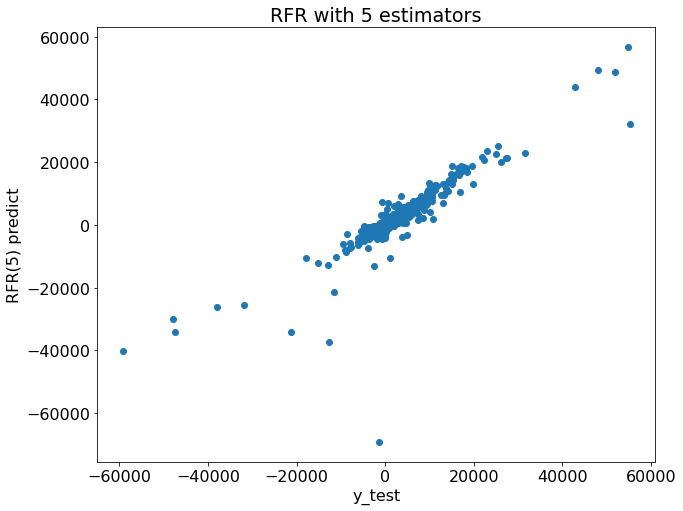

------------Running RFR with 10 estimators ------------
RSq =  0.8553


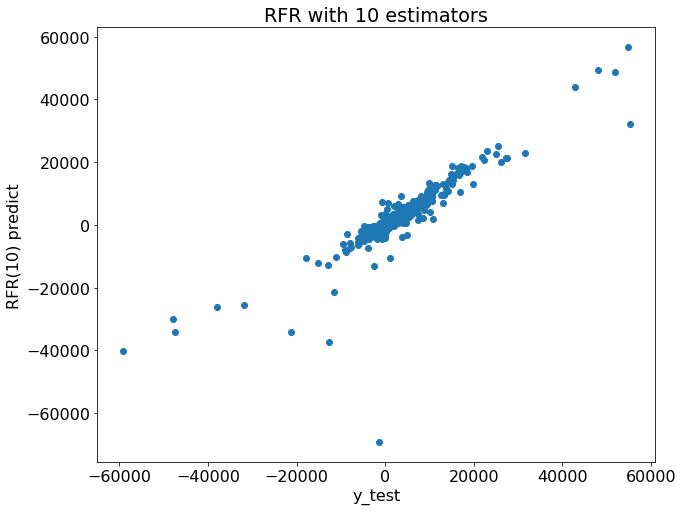

------------Running RFR with 15 estimators ------------
RSq =  0.8737


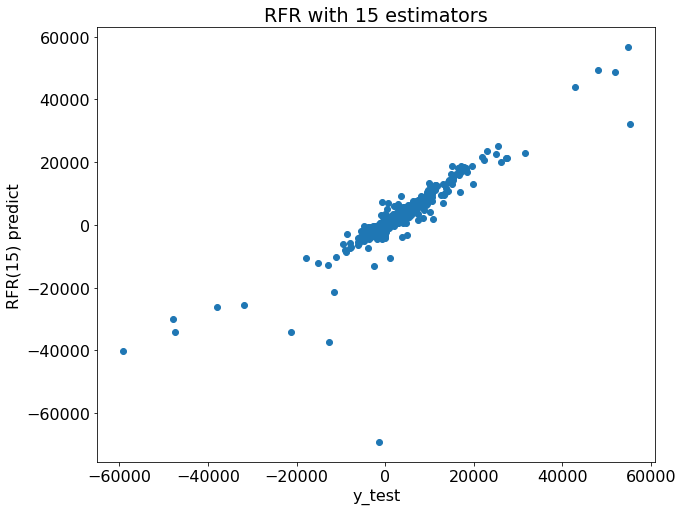

------------Running RFR with 20 estimators ------------
RSq =  0.8730


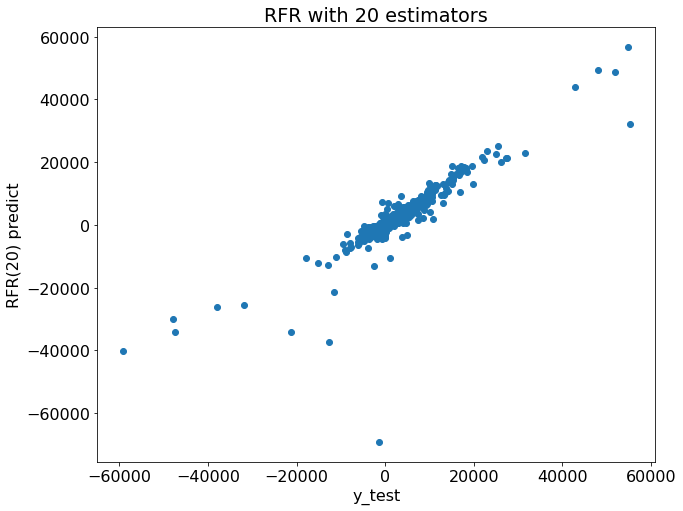

------------Running RFR with 25 estimators ------------
RSq =  0.8824


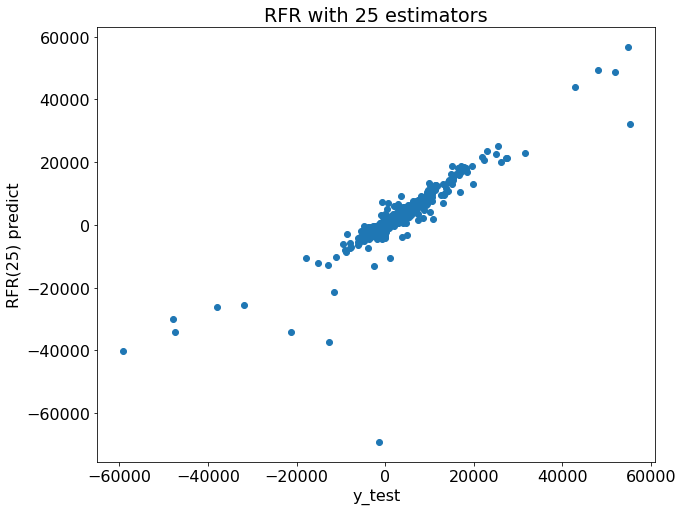

In [187]:
EXPL_VAR = 0.05

%run ./mobilityMLhelpers.ipynb
mlHelpers = mobilityMLhelpers()

pca, X_train, X_test, y_train, y_test = \
    mlHelpers.runPCA(EXPL_VAR, myPCAdata, verbose=True)

%run ./mobilityMLhelpers.ipynb
mlHelpers = mobilityMLhelpers()

print()
for nn in (5, 10, 15, 20, 25):
    print(f"""------------Running RFR with {nn} estimators ------------""" )
    rsq, rfr = mlHelpers.fitRFR(nn, X_train, y_train, X_test, y_test)

To reconstruct the original values, use https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com